<a href="https://colab.research.google.com/github/DanielaRodriguez0/Estadistica/blob/main/Proyecto_MOD_ME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

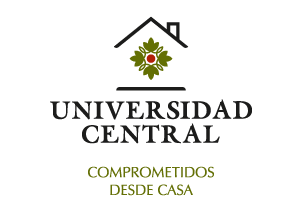

## **Trabajo Final. Base de datos Paysim**

>>**Universidad Central**<br>
>>**Facultad de Ingeniería y Ciencias Básicas**<br>
>>**Maestría de Analítica de Datos**<br>
>>**Métodos Estadísticos - 2022 - I**

>>>*Docente: Nelson Alirio Cruz* <br>  

>>>*Presentado por:*

>>> - Luz Elena Ordoñez Patiño<br>
>>> - Diego Armando Baquero Gutiérrez<br>
>>> - Daniela Rodríguez Fonseca<br>
>>> - Andrés Javier Parra Ávila

>---

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
### recursive feature elimination.
from sklearn.feature_selection import RFE
### entrenamiento y prueba
from sklearn.model_selection import train_test_split
### Para arboles
from sklearn import linear_model, tree
### Matrices de confusion
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
### validacion cruzada
from sklearn.model_selection import GridSearchCV
!pip install dtreeviz
### Arboles 
from dtreeviz.trees import dtreeviz
import graphviz

import seaborn as sns
 
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
 
from pylab import rcParams
 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 97 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=50c67aed4e315daf3fa7317ddc6a13a4724490b1552c606d8f05fe3cc6a7d77c
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


# Comprensión de la base

La base de datos seleccionada emplea un conjunto de datos sintéticos generados a partir del simulador PaySim. Este utiliza datos agregados del conjunto de datos privados y genera un conjunto de datos sintéticos que simula operaciones normales de transacciones y proyecta comportamiento malicioso para luego evaluar el desempeño de los métodos de detección de fraude.

PaySim simula transacciones de dinero móvil basándose en una muestra de transacciones reales extraídas de un mes de registros financieros de un servicio de dinero móvil implementado en un país africano.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta="/content/drive/MyDrive/Métodos Estadísticos/Proyecto Métodos Estadísticos/base_fraude.csv"
fraude = pd.read_csv(ruta, sep=",") ; fraude

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
fraude.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Eliminamos las varibales nameOrig, nameDesty y step ya que estas no aportan información relevante al árbol de decisión.

In [ ]:
del(fraude['nameOrig'])
del(fraude['nameDest'])
del(fraude['step'])
fraude

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0


In [ ]:
fraudedummy=pd.get_dummies(fraude["type"], prefix="type")
fraude = pd.concat([fraude, fraudedummy], axis = 1)
del(fraude['type'])
fraude

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,1,0,0,0
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,0,1
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,0,1


In [ ]:
fraude.groupby("isFraud").size()/fraude.shape[0]

isFraud
0    0.998709
1    0.001291
dtype: float64

Dado que los datos están desbalanceados, no se usará accuracy como métrica

# Árbol de Clasificación

### Entrenamiento y prueba

Para la división del conjunto de datos en train y test se utilizan los siguientes parámetros:

- test_size= 0.2: el set de train queda con el 80% de los datos y el de test con el 20% de los datos.
- stratify= Y: conserva las proporciones de clase en el train y en el test. 'Y' debe ser categorica.
- random_state=1234: es una semilla.

In [ ]:
Y = fraude["isFraud"] ### fraude o no
X = fraude.drop("isFraud", axis=1) ## Todo lo demás
## Division de los datos
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.2, stratify= Y, random_state= 1234) ### Garantiza la misma proporcion 
# Convertimos en dataframe y sacamos las proporciones
pd.DataFrame(y_train).groupby("isFraud").size()/sum(pd.DataFrame(y_train).groupby("isFraud").size())

isFraud
0    0.998709
1    0.001291
dtype: float64

### Validacion cruzada
Definir parametros

1. Profundidad 2,3,4,5
2. Gini o Entropy
3. Definir la métrica

En este punto, debemos manejar variables dummie

In [ ]:
y1_train=pd.get_dummies(y_train, drop_first=True) ## Volverla dummie
### Validacion cruzada para obtener la profundidad optima
parameters = {'max_depth':range(2,5), 'criterion':['gini', 'entropy']} 
arbol= GridSearchCV(tree.DecisionTreeClassifier(), parameters,scoring="precision", n_jobs=-1) ## Metrica BAcc
arbol.fit(X=X_train, y=y1_train)
tree_model = arbol.best_estimator_ ## El mejor modelo
print (arbol.best_score_, arbol.best_params_) 

0.9896449738492292 {'criterion': 'gini', 'max_depth': 2}


Si la máxima profundidad hubiera sido igual al máximo ingresado, debemos ampliar el rango. 

#### Mejor combinación
Probando los parametros, la mejor combinación fue {'criterion': 'gini', 'max_depth': 2} con una precisión de  0.9896449738492292 

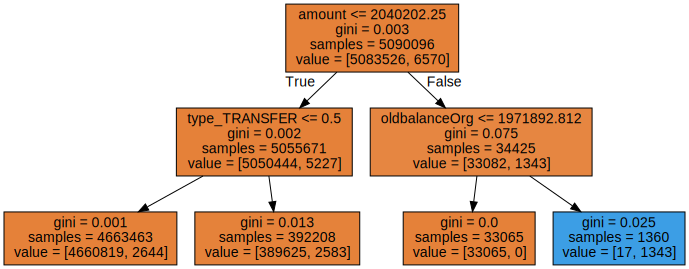

In [ ]:
arbol=tree.DecisionTreeClassifier(criterion="gini", max_depth=2)
arbol.fit(X_train, y_train)
dot_data = tree.export_graphviz(arbol, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [ ]:
arbol

DecisionTreeClassifier(max_depth=2)

In [ ]:
print("Profundidad (depth) = ",arbol.get_depth())
print("Nodos terminales    = ",arbol.get_n_leaves())

Profundidad (depth) =  2
Nodos terminales    =  4


#### Resultados
Probamos ese arbol

In [ ]:
y_pred_train=arbol.predict(X_train)
y_pred_test=arbol.predict(X_test)
print("En los datos de entrenamiento \n",classification_report(y_train, y_pred_train, digits=5))
print("En los datos de prueba \n",classification_report(y_test, y_pred_test, digits=5))

En los datos de entrenamiento 
               precision    recall  f1-score   support

           0    0.99897   1.00000   0.99948   5083526
           1    0.98750   0.20441   0.33871      6570

    accuracy                        0.99897   5090096
   macro avg    0.99324   0.60221   0.66910   5090096
weighted avg    0.99896   0.99897   0.99863   5090096

En los datos de prueba 
               precision    recall  f1-score   support

           0    0.99896   1.00000   0.99948   1270881
           1    0.99377   0.19416   0.32485      1643

    accuracy                        0.99896   1272524
   macro avg    0.99636   0.59708   0.66216   1272524
weighted avg    0.99895   0.99896   0.99861   1272524



* La probabilidad de que el modelo detecte un fraude es del 0,194, es decir que la certeza del modelo es del 19,4%.
* Si el modelo detecta un fraude, la probabilidad de que sea un fraude es del 98%.
* Dado que las distancias entre los datos de entrenamiento y los datos de prueba es mínima (lejos del 10%) se puede concluir que el modelo no está sobreajustado.

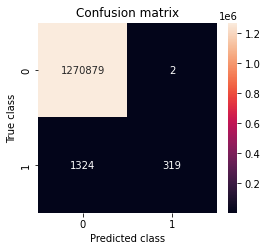

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3.5))
sns.heatmap(conf_matrix, xticklabels='01', yticklabels='01', annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Los resultados de la matriz de confusión muestran que 
* 1'270.879 fueron pronosticados como no fraude y efectivamente eran no fraude
* 1324 el modelo los clasificó como no fraude pero si lo eran
* 2 el modelo dijo que eran fraude pero no lo eran
* 319 eran fraudes y pronosticados como tal.
* La probabilidad de que sea fraude es (1.324+319)/(1.324+319+1'270.879+2) = 1.643/1'272.524 = 0,00129 = 1.290/1'000.000
* La probabilidad de detectar un fraude dado que es fraude es 319/1.643 = 0,194 = 194/1.000
* (1,290 * 194) / (1.000 * 1,290) = 250.26/1290 de cada 1290 fraudes, el modelo deja pasar 1.039 de 1 millón de transacciones, lo cual es muy malo.
* La probabilidad de que no sea fraude y las pronostiqué como no fraude es 1'270.879/1'272.203 = 0,99895 es decir que de cada millón de transacciones el modelo no previene (se equivoca) 1.040 estafas.

## Podando con $\alpha$, sin validación cruzada

La poda es una de las técnicas que sirve para evitar el sobreajuste. Así como su nombre lo indica, este proceso implica la eliminación selectiva de ciertas partes como ramas y hojas, para mejorar la estructura del árbol. Esta práctica hace versátil el modelo para que pueda adaptarse al momento de proporcionar nuevos datos, solucionando así el problema del sobreajuste. 

La poda también reduce el tamaño de un árbol de decisiones, lo que puede aumentar ligeramente el error de entrenamiento, pero reduce drásticamente el error de prueba, lo que lo hace más adaptable.

Text(0.5, 1.0, 'Entropia total vs valor de alpha')

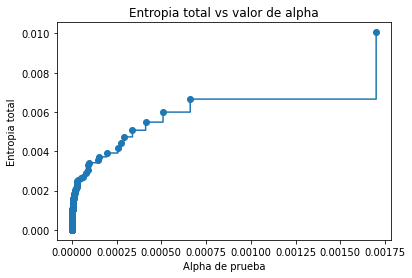

In [ ]:
arbol = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Alpha de prueba")
ax.set_ylabel("Entropia total")
ax.set_title("Entropia total vs valor de alpha")

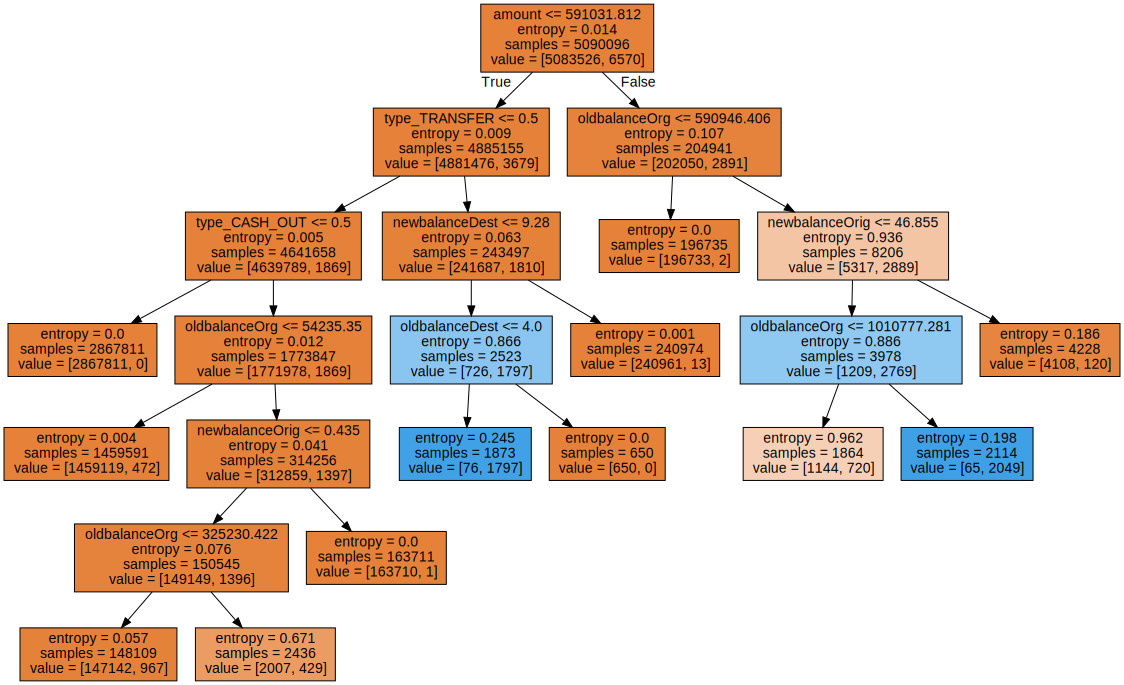

In [ ]:
arbol=tree.DecisionTreeClassifier(criterion="entropy",ccp_alpha=0.00025)
arbol.fit(X_train, y_train)
dot_data = tree.export_graphviz(arbol, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [ ]:
print("Profundidad (depth) = ",arbol.get_depth())
print("Nodos terminales    = ",arbol.get_n_leaves())

Profundidad (depth) =  6
Nodos terminales    =  12


#### Resultados FALTA DIEGOO :D

In [ ]:
arbol=tree.DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.00025)## Cambiar el ccc_alpha
arbol.fit(X_train, y_train)
y_pred_train=arbol.predict(X_train)
y_pred_test=arbol.predict(X_test)
print("En los datos de entrenamiento \n",classification_report(y_train, y_pred_train, digits=5))
print("En los datos de prueba \n",classification_report(y_test, y_pred_test, digits=5))

En los datos de entrenamiento 
               precision    recall  f1-score   support

           0    0.99946   0.99997   0.99972   5083526
           1    0.96464   0.58539   0.72862      6570

    accuracy                        0.99944   5090096
   macro avg    0.98205   0.79268   0.86417   5090096
weighted avg    0.99942   0.99944   0.99937   5090096

En los datos de prueba 
               precision    recall  f1-score   support

           0    0.99947   0.99998   0.99972   1270881
           1    0.96894   0.58856   0.73230      1643

    accuracy                        0.99944   1272524
   macro avg    0.98420   0.79427   0.86601   1272524
weighted avg    0.99943   0.99944   0.99938   1272524



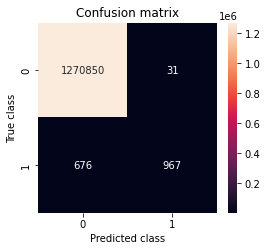

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3.5))
sns.heatmap(conf_matrix, xticklabels='01', yticklabels='01', annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Text(0.5, 1.0, 'Gini versus valor de alpha')

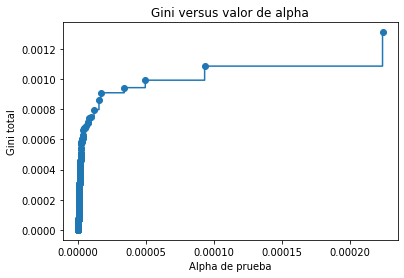

In [ ]:
arbol = tree.DecisionTreeClassifier(criterion="gini", random_state=0)
alpha= arbol.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = alpha.ccp_alphas, alpha.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Alpha de prueba")
ax.set_ylabel("Gini total")
ax.set_title("Gini versus valor de alpha")

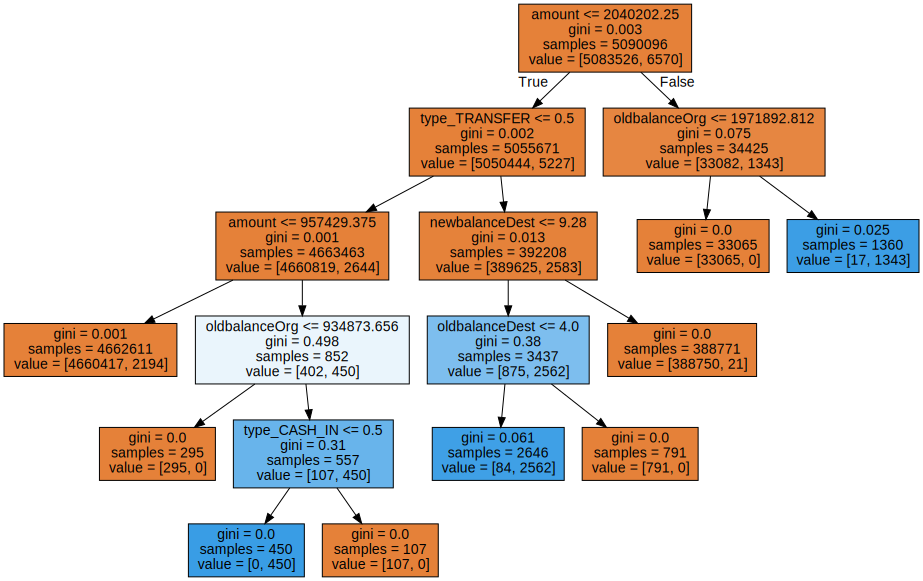

In [ ]:
arbol=tree.DecisionTreeClassifier(criterion="gini",ccp_alpha=0.00002)
arbol.fit(X_train, y_train)
dot_data = tree.export_graphviz(arbol, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [ ]:
print("Profundidad (depth) = ",arbol.get_depth())
print("Nodos terminales    = ",arbol.get_n_leaves())

Profundidad (depth) =  5
Nodos terminales    =  9


In [ ]:
arbol=tree.DecisionTreeClassifier(criterion="gini", ccp_alpha=0.00002)## Cambiar el ccc_alpha
arbol.fit(X_train, y_train)
y_pred_train=arbol.predict(X_train)
y_pred_test=arbol.predict(X_test)
print("En los datos de entrenamiento \n",classification_report(y_train, y_pred_train, digits=5))
print("En los datos de prueba \n",classification_report(y_test, y_pred_test, digits=5))

En los datos de entrenamiento 
               precision    recall  f1-score   support

           0    0.99956   0.99998   0.99977   5083526
           1    0.97733   0.66286   0.78995      6570

    accuracy                        0.99954   5090096
   macro avg    0.98845   0.83142   0.89486   5090096
weighted avg    0.99954   0.99954   0.99950   5090096

En los datos de prueba 
               precision    recall  f1-score   support

           0    0.99958   0.99998   0.99978   1270881
           1    0.97878   0.67377   0.79813      1643

    accuracy                        0.99956   1272524
   macro avg    0.98918   0.83687   0.89895   1272524
weighted avg    0.99955   0.99956   0.99952   1272524



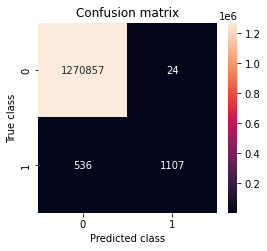

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3.5))
sns.heatmap(conf_matrix, xticklabels='01', yticklabels='01', annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### Resultados FALTA DIEGOO :D

## Árbol de Clasificación con datos balanceados

A continuación, se realiza la construcción del árbol de clasificación incluyendo un parámetro para balancear los datos y el criterio 'gini', teniendo en cuenta los resultados de los árboles anteriores.

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    arbolA = tree.DecisionTreeClassifier(random_state=21,class_weight="balanced", criterion="gini", max_depth = 19)
    arbolA.fit(X_train, y_train)
    return arbolA
 
arbolA = run_model_balanced(X_train, X_test, y_train, y_test)

# Se dibuja el árbol
dot_data = tree.export_graphviz(arbolA, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 

In [ ]:
print("Profundidad (depth) = ",arbolA.get_depth())
print("Nodos terminales    = ",arbolA.get_n_leaves())

Profundidad (depth) =  19
Nodos terminales    =  1060


El árbol con parámetros de profundidad 19 y criterio 'gini', tiene 1004 nodos terminales, lo cual dificulta su visualización, como se observa en la gráfica anterior.

In [ ]:
y_pred_train = arbolA.predict(X_train)
y_pred_test = arbolA.predict(X_test)
print("En los datos de entrenamiento \n",classification_report(y_train, y_pred_train, digits = 5))
print("En los datos de prueba \n",classification_report(y_test, y_pred_test, digits = 5))

En los datos de entrenamiento 
               precision    recall  f1-score   support

           0    1.00000   0.99974   0.99987   5083526
           1    0.83503   1.00000   0.91010      6570

    accuracy                        0.99974   5090096
   macro avg    0.91751   0.99987   0.95499   5090096
weighted avg    0.99979   0.99974   0.99976   5090096

En los datos de prueba 
               precision    recall  f1-score   support

           0    0.99989   0.99967   0.99978   1270881
           1    0.77934   0.91357   0.84113      1643

    accuracy                        0.99955   1272524
   macro avg    0.88961   0.95662   0.92045   1272524
weighted avg    0.99960   0.99955   0.99957   1272524



* La probabilidad de que el modelo detecte un fraude es del 0,9056, es decir que la certeza del modelo es del 90,56%.
* Si el modelo detecta un fraude, la probabilidad de que sea un fraude es del 72.4%.
* Dado que las distancias entre los datos de entrenamiento y los datos de prueba es mínima, no supera el 10%; se puede concluir que el modelo no está sobreajustado.

### Resultados

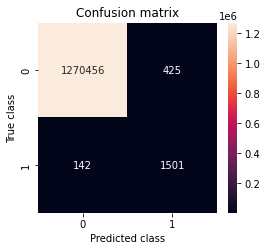

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (4, 3.5))
sns.heatmap(conf_matrix, xticklabels= '01', yticklabels= '01', annot = True, fmt= "d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

A continuación, se realiza el análisis dela matriz de confusión, los resultados muestran que:

* 1'270.456 fueron pronosticados como no fraude y efectivamente eran no fraude.
* 142 transacciones el modelo las clasificó como no fraude pero si lo eran.
* 425 transacciones el modelo dijo que eran fraude pero no lo eran.
* 1501 eran fraudes y fueron pronosticados como tal.
* La probabilidad de que sea fraude es $\frac{142 + 1501}{142 + 1501 + 1270456 + 425}=0.001291$
$=\frac{1291}{1000000}$
<br>
<br>
* La probabilidad de detectar un fraude dado que es fraude es $\frac{1501}{1643}=0.913$
$=\frac{913}{1000}$
<br>
<br>
* $\frac{1291 * 913}{1.000 + 1291} =\frac{514.48}{1291}$ de cada 1291 fraudes, el modelo deja pasar 777 de 1 millón de transacciones, lo cual es muy malo.
<br>
<br>
* La probabilidad de que no sea fraude y las pronostique como no fraude es $\frac{1270456}{1270598}=0.99988$; es decir, que de cada millón de transacciones el modelo no previene (se equivoca) 777 estafas.


### DIEGO AYUDA NO LAS ENTENDÍ

* (1,290 * 194) / (1.000 * 1,290) = 250.26/1290 de cada 1290 fraudes, el modelo deja pasar 1.039 de 1 millón de transacciones, lo cual es muy malo.
* La probabilidad de que no sea fraude y las pronostique como no fraude es $\frac{1270315}{1270470}=0.99987$; es decir, que de cada millón de transacciones el modelo no previene (se equivoca) 1.040 estafas.

# Regresión Logística

In [ ]:
df = pd.read_csv(ruta, sep=",")
del(df['nameOrig'])
del(df['nameDest'])
del(df['step'])
dfdummy=pd.get_dummies(df["type"], prefix="type")
df = pd.concat([df, dfdummy], axis = 1)
del(df['type'])
df.head(n=5)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [ ]:
print(df.shape)
print(pd.value_counts(df['isFraud'], sort = True))

(6362620, 12)
0    6354407
1       8213
Name: isFraud, dtype: int64


In [ ]:
df.groupby("isFraud").size()/df.shape[0]

isFraud
0    0.998709
1    0.001291
dtype: float64

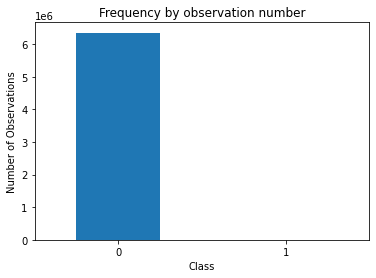

In [ ]:
count_classes = pd.value_counts(df['isFraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), '01')
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

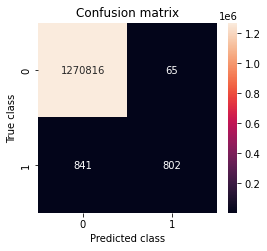

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.93      0.49      0.64      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
y = df['isFraud']
X = df.drop('isFraud', axis=1)
#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,stratify=y)
 
#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base
 
#ejecutamos el modelo "tal cual"
model = run_model(X_train, X_test, y_train, y_test)
 
#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(4, 3.5))
    sns.heatmap(conf_matrix, xticklabels='01', yticklabels='01', annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))
 
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Resultados FALTA ANDRÉS :D

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

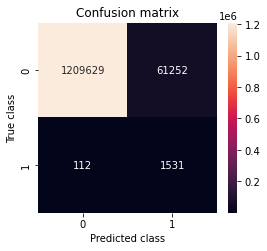

              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1270881
           1       0.02      0.93      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.94      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524



In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf
 
model = run_model_balanced(X_train, X_test, y_train, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Resultados FALTA ANDRÉS :D

# Conclusiones ANDRÉSSSSSSSS! :P

# Bibliografía

* Base de datos [paysim1](https://www.kaggle.com/datasets/ealaxi/paysim1)
* Datos desbalanceados [Clasificación con datos desbalanceados](https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/)